## qwen定位

In [1]:
import os
import json
import torch
from PIL import Image
from tqdm import tqdm
import numpy as np
from transformers import Qwen2_5_VLForConditionalGeneration, AutoProcessor

# ========== 配置 ==========
TEXT_DIR = '/data/guojian.li/Dataset/MSTI/Textual sentences/test'  # 假设文本在此目录
VISUAL_LABEL_DIR = '/data/guojian.li/Dataset/MSTI/Visual target labels/'
IMAGE_DIR = '/data/guojian.li/Dataset/MSTI/img'
MODEL_PATH = '/data/guojian.li/Weight/Qwen2.5-VL-7B-Instruct'
DEVICE = 'cuda:1' if torch.cuda.is_available() else 'cpu'

# ========== VOC AP工具 ==========
def voc_ap(rec, prec, use_07_metric=False):
    if use_07_metric:
        ap = 0.
        for t in np.arange(0., 1.1, 0.1):
            if np.sum(rec >= t) == 0:
                p = 0
            else:
                p = np.max(prec[rec >= t])
            ap = ap + p / 11.
    else:
        mrec = np.concatenate(([0.], rec, [1.]))
        mpre = np.concatenate(([0.], prec, [0.]))
        for i in range(mpre.size - 1, 0, -1):
            mpre[i - 1] = np.maximum(mpre[i - 1], mpre[i])
        i = np.where(mrec[1:] != mrec[:-1])[0]
        ap = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])
    return ap

def voc_eval(preds, targets, threshold=0.5, use_07_metric=False):
    if len(preds) == 0:
        return 0.0
    image_ids = [x[0] for x in preds]
    confidence = np.array([float(x[1]) for x in preds])
    BB = np.array([x[2:] for x in preds])
    if BB.size == 0 or BB.ndim != 2:
        return 0.0
    sorted_ind = np.argsort(-confidence)
    BB = BB[sorted_ind, :]
    image_ids = [image_ids[x] for x in sorted_ind]
    npos = sum([len(targets[k]) for k in targets])
    nd = len(image_ids)
    tp = np.zeros(nd)
    fp = np.zeros(nd)
    for d, image_id in enumerate(image_ids):
        bb = BB[d]
        if image_id in targets:
            BBGT = [gt for gt in targets[image_id]]
            match = False
            for bbgt in BBGT:
                ixmin = np.maximum(bbgt[0], bb[0])
                iymin = np.maximum(bbgt[1], bb[1])
                ixmax = np.minimum(bbgt[2], bb[2])
                iymax = np.minimum(bbgt[3], bb[3])
                iw = np.maximum(ixmax - ixmin + 1., 0.)
                ih = np.maximum(iymax - iymin + 1., 0.)
                inters = iw * ih
                union = (bb[2] - bb[0] + 1.) * (bb[3] - bb[1] + 1.) + (bbgt[2] - bbgt[0] + 1.) * (bbgt[3] - bbgt[1] + 1.) - inters
                overlaps = inters / union if union > 0 else 0
                if overlaps > threshold:
                    tp[d] = 1
                    match = True
                    targets[image_id].remove(bbgt)
                    break
            fp[d] = 0 if match else 1
        else:
            fp[d] = 1
    fp = np.cumsum(fp)
    tp = np.cumsum(tp)
    rec = tp / float(npos) if npos > 0 else np.zeros_like(tp)
    prec = tp / np.maximum(tp + fp, np.finfo(np.float64).eps)
    ap = voc_ap(rec, prec, use_07_metric)
    return ap

# ========== 工具函数 ==========
def load_gt_boxes(label_file):
    gt_boxes = []
    with open(label_file, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.strip().split()
            # 全为0，直接跳过
            if all(p == '0' for p in parts):
                continue
            i = 0
            while i + 4 < len(parts):
                x1, y1, x2, y2 = map(float, parts[i:i+4])
                # 目标全为0也跳过
                if x1 == 0 and y1 == 0 and x2 == 0 and y2 == 0:
                    i += 5
                    continue
                gt_boxes.append([x1, y1, x2, y2])
                i += 5  # 跳过class字段
    return gt_boxes

def load_text(text_file):
    with open(text_file, 'r', encoding='utf-8') as f:
        return f.read().strip()

def parse_qwen_output(output):
    try:
        if '```json' in output:
            output = output.split('```json')[1].split('```')[0]
        boxes = json.loads(output)
        return [b['bbox_2d'] for b in boxes if 'bbox_2d' in b]
    except Exception as e:
        print('Qwen输出解析失败:', e)
        return []

def iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = max(0, boxA[2] - boxA[0]) * max(0, boxA[3] - boxA[1])
    boxBArea = max(0, boxB[2] - boxB[0]) * max(0, boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea + 1e-6)
    return iou

def qwen_infer(image_path, text, prompt, model, processor):
    image = Image.open(image_path).convert('RGB')
    messages = [
        {"role": "system", "content": "你是一个图文讽刺目标定位助手"},
        {"role": "user", "content": [
            {"type": "text", "text": prompt + "\n推文内容：" + text},
            {"image": image_path}
        ]}
    ]
    text_input = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    inputs = processor(text=[text_input], images=[image], padding=True, return_tensors="pt").to(DEVICE)
    output_ids = model.generate(**inputs, max_new_tokens=512)
    generated_ids = [output_ids[len(input_ids):] for input_ids, output_ids in zip(inputs.input_ids, output_ids)]
    output_text = processor.batch_decode(generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True)
    return output_text[0]

# ========== 主流程 ==========
def main():
    print('加载Qwen2.5-VL模型...')
    model = Qwen2_5_VLForConditionalGeneration.from_pretrained(MODEL_PATH, torch_dtype=torch.bfloat16, attn_implementation="flash_attention_2", device_map=DEVICE)
    processor = AutoProcessor.from_pretrained(MODEL_PATH)

    label_files = [f for f in os.listdir(VISUAL_LABEL_DIR) if f.endswith('.txt')]
    print(f'共{len(label_files)}张图片')

    gt_dict = {}
    pred_list = []
    em_list = []
    f1_list = []
    prompt = "请结合推文内容和图片，找出图片中被讽刺的目标，并以JSON格式输出所有目标的[x1,y1,x2,y2]像素坐标，格式为[{\"bbox_2d\":[x1,y1,x2,y2]}]。"

    for label_file in tqdm(label_files):
        imgid = os.path.splitext(label_file)[0]
        img_path = os.path.join(IMAGE_DIR, f'{imgid}.jpg')
        label_path = os.path.join(VISUAL_LABEL_DIR, label_file)
        text_path = os.path.join(TEXT_DIR, f'{imgid}.txt')
        if not (os.path.exists(img_path) and os.path.exists(text_path)):
            continue
        gt_boxes = load_gt_boxes(label_path)
        gt_dict[imgid] = [box for box in gt_boxes]  # 即使为空也要加
        text = load_text(text_path)
        output = qwen_infer(img_path, text, prompt, model, processor)
        pred_boxes = parse_qwen_output(output)
        pred_boxes = [[float(x) for x in box] for box in pred_boxes]
        # EM/F1逻辑
        if not gt_boxes and not pred_boxes:
            em = 1
            f1 = 1
        elif not gt_boxes and pred_boxes:
            em = 0
            f1 = 0
        elif gt_boxes and not pred_boxes:
            em = 0
            f1 = 0
        else:
            em = int(sorted(pred_boxes) == sorted(gt_boxes))
            matched_pred = set()
            matched_gt = set()
            for i, pb in enumerate(pred_boxes):
                for j, gb in enumerate(gt_boxes):
                    if j in matched_gt:
                        continue
                    if iou(pb, gb) >= 0.5:
                        matched_pred.add(i)
                        matched_gt.add(j)
                        break
            tp = len(matched_pred)
            fp = len(pred_boxes) - tp
            fn = len(gt_boxes) - tp
            precision = tp / (tp + fp + 1e-6)
            recall = tp / (tp + fn + 1e-6)
            f1 = 2 * precision * recall / (precision + recall + 1e-6) if (precision+recall)>0 else 0
        em_list.append(em)
        f1_list.append(f1)
        for pb in pred_boxes:
            pred_list.append([imgid, 1.0, pb[0], pb[1], pb[2], pb[3]])

    thresholds = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
    aps = []
    for th in thresholds:
        aps.append(voc_eval(pred_list, {k: [b for b in v] for k, v in gt_dict.items()}, threshold=th))
    ap = np.mean(aps)
    ap50 = aps[0]
    ap75 = aps[5]
    print(f'EM: {np.mean(em_list):.4f}')
    print(f'F1: {np.mean(f1_list):.4f}')
    print(f'AP: {ap:.4f}')
    print(f'AP50: {ap50:.4f}')
    print(f'AP75: {ap75:.4f}')

if __name__ == '__main__':
    main()

/opt/conda/envs/video-r1/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[2025-06-19 11:50:40,364] [INFO] [real_accelerator.py:219:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/opt/conda/envs/video-r1/compiler_compat/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status
/opt/conda/envs/video-r1/compiler_compat/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status


加载Qwen2.5-VL模型...


Loading checkpoint shards: 100%|██████████| 5/5 [00:03<00:00,  1.42it/s]
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


共5015张图片


  5%|▍         | 241/5015 [00:38<12:11,  6.53it/s]

Qwen输出解析失败: Expecting value: line 1 column 1 (char 0)


 10%|█         | 513/5015 [01:28<06:51, 10.94it/s]

Qwen输出解析失败: Expecting value: line 1 column 1 (char 0)


 36%|███▌      | 1803/5015 [05:40<09:10,  5.84it/s]

Qwen输出解析失败: Expecting value: line 1 column 1 (char 0)


 79%|███████▊  | 3937/5015 [13:06<02:09,  8.32it/s]

Qwen输出解析失败: Expecting value: line 1 column 1 (char 0)


 95%|█████████▍| 4750/5015 [15:44<00:40,  6.51it/s]

Qwen输出解析失败: Expecting value: line 1 column 1 (char 0)


100%|██████████| 5015/5015 [16:26<00:00,  5.08it/s]

EM: 0.0189
F1: 0.1875
AP: 0.0275
AP50: 0.0595
AP75: 0.0262


In [1]:
import os
import json
import torch
from PIL import Image
from tqdm import tqdm
import numpy as np
from transformers import Qwen2_5_VLForConditionalGeneration, AutoProcessor

# ========== 配置 ==========
TEXT_DIR = '/data/guojian.li/Dataset/MSTI/Textual sentences/test'  # 假设文本在此目录
VISUAL_LABEL_DIR = '/data/guojian.li/Dataset/MSTI/Visual target labels/'
IMAGE_DIR = '/data/guojian.li/Dataset/MSTI/img'
MODEL_PATH = '/data/guojian.li/Weight/Qwen2.5-VL-7B-Instruct'
# MODEL_PATH = '/data/guojian.li/Project/Video-R1/src/r1-v/log/Qwen2.5-VL-7B-sarcasm-sft'
DEVICE = 'cuda:1' if torch.cuda.is_available() else 'cpu'


# ========== VOC AP工具 ==========
def voc_ap(rec, prec, use_07_metric=False):
    if use_07_metric:
        ap = 0.
        for t in np.arange(0., 1.1, 0.1):
            if np.sum(rec >= t) == 0:
                p = 0
            else:
                p = np.max(prec[rec >= t])
            ap = ap + p / 11.
    else:
        mrec = np.concatenate(([0.], rec, [1.]))
        mpre = np.concatenate(([0.], prec, [0.]))
        for i in range(mpre.size - 1, 0, -1):
            mpre[i - 1] = np.maximum(mpre[i - 1], mpre[i])
        i = np.where(mrec[1:] != mrec[:-1])[0]
        ap = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])
    return ap

def voc_eval(preds, targets, threshold=0.5, use_07_metric=False):
    if len(preds) == 0:
        return 0.0
    image_ids = [x[0] for x in preds]
    confidence = np.array([float(x[1]) for x in preds])
    BB = np.array([x[2:] for x in preds])
    if BB.size == 0 or BB.ndim != 2:
        return 0.0
    sorted_ind = np.argsort(-confidence)
    BB = BB[sorted_ind, :]
    image_ids = [image_ids[x] for x in sorted_ind]
    npos = sum([len(targets[k]) for k in targets])
    nd = len(image_ids)
    tp = np.zeros(nd)
    fp = np.zeros(nd)
    for d, image_id in enumerate(image_ids):
        bb = BB[d]
        if image_id in targets:
            BBGT = [gt for gt in targets[image_id]]
            match = False
            for bbgt in BBGT:
                ixmin = np.maximum(bbgt[0], bb[0])
                iymin = np.maximum(bbgt[1], bb[1])
                ixmax = np.minimum(bbgt[2], bb[2])
                iymax = np.minimum(bbgt[3], bb[3])
                iw = np.maximum(ixmax - ixmin + 1., 0.)
                ih = np.maximum(iymax - iymin + 1., 0.)
                inters = iw * ih
                union = (bb[2] - bb[0] + 1.) * (bb[3] - bb[1] + 1.) + (bbgt[2] - bbgt[0] + 1.) * (bbgt[3] - bbgt[1] + 1.) - inters
                overlaps = inters / union if union > 0 else 0
                if overlaps > threshold:
                    tp[d] = 1
                    match = True
                    targets[image_id].remove(bbgt)
                    break
            fp[d] = 0 if match else 1
        else:
            fp[d] = 1
    fp = np.cumsum(fp)
    tp = np.cumsum(tp)
    rec = tp / float(npos) if npos > 0 else np.zeros_like(tp)
    prec = tp / np.maximum(tp + fp, np.finfo(np.float64).eps)
    ap = voc_ap(rec, prec, use_07_metric)
    return ap

# ========== 工具函数 ==========
def load_gt_boxes(label_file):
    gt_boxes = []
    with open(label_file, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.strip().split()
            # 全为0，直接跳过（class为0的样本）
            if all(p == '0' for p in parts):
                return []  # 直接返回空，主循环会跳过
            i = 0
            while i + 4 < len(parts):
                x1, y1, x2, y2 = map(float, parts[i:i+4])
                # 目标全为0也跳过
                if x1 == 0 and y1 == 0 and x2 == 0 and y2 == 0:
                    i += 5
                    continue
                gt_boxes.append([x1, y1, x2, y2])
                i += 5  # 跳过class字段
    return gt_boxes

def load_text(text_file):
    with open(text_file, 'r', encoding='utf-8') as f:
        return f.read().strip()

def parse_qwen_output(output):
    try:
        if '```json' in output:
            output = output.split('```json')[1].split('```')[0]
        boxes = json.loads(output)
        return [b['bbox_2d'] for b in boxes if 'bbox_2d' in b]
    except Exception as e:
        print(output)
        print('Qwen输出解析失败:', e)
        return []

def qwen_infer(image_path, text, prompt, model, processor):
    image = Image.open(image_path).convert('RGB')
    messages = [
        {"role": "system", "content": "你是一个图文讽刺目标定位助手"},
        {"role": "user", "content": [
            {"type": "text", "text": prompt + "\n推文内容：" + text},
            {"image": image_path}
        ]}
    ]
    text_input = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    inputs = processor(text=[text_input], images=[image], padding=True, return_tensors="pt").to(DEVICE)
    output_ids = model.generate(**inputs, max_new_tokens=1024)
    generated_ids = [output_ids[len(input_ids):] for input_ids, output_ids in zip(inputs.input_ids, output_ids)]
    output_text = processor.batch_decode(generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True)
    return output_text[0]

# ========== 主流程 ==========
def main():
    print('加载Qwen2.5-VL模型...')
    model = Qwen2_5_VLForConditionalGeneration.from_pretrained(MODEL_PATH, torch_dtype=torch.bfloat16, attn_implementation="flash_attention_2", device_map=DEVICE)
    processor = AutoProcessor.from_pretrained(MODEL_PATH)

    label_files = [f for f in os.listdir(VISUAL_LABEL_DIR) if f.endswith('.txt')]
    print(f'共{len(label_files)}张图片')

    num_images = 0 # 实际图片数量

    gt_dict = {}
    pred_list = []
    prompt = """Please combine the content of the tweet and the pictures to identify the targets being ridiculed in the pictures, 
    and output the pixel coordinates of all the targets in JSON format, 
    in formats such as [{\"bbox_2d\":[x1,y1,x2,y2]},{\"bbox_2d\":[x1,y1,x2,y2]}]. If it does not exist, return []."""

    for label_file in tqdm(label_files):
        imgid = os.path.splitext(label_file)[0]
        img_path = os.path.join(IMAGE_DIR, f'{imgid}.jpg')
        label_path = os.path.join(VISUAL_LABEL_DIR, label_file)
        text_path = os.path.join(TEXT_DIR, f'{imgid}.txt')
        if not (os.path.exists(img_path) and os.path.exists(text_path)):
            continue
        gt_boxes = load_gt_boxes(label_path)
        # 跳过class为0的样本（即gt_boxes==[]）
        if not gt_boxes:
            continue
        num_images += 1
        gt_dict[imgid] = [box for box in gt_boxes]
        text = load_text(text_path)
        output = qwen_infer(img_path, text, prompt, model, processor)
        pred_boxes = parse_qwen_output(output)
        pred_boxes = [[float(x) for x in box] for box in pred_boxes]
        for pb in pred_boxes:
            pred_list.append([imgid, 1.0, pb[0], pb[1], pb[2], pb[3]])

    thresholds = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
    aps = []
    for th in thresholds:
        aps.append(voc_eval(pred_list, {k: [b for b in v] for k, v in gt_dict.items()}, threshold=th))
    ap = np.mean(aps)
    ap50 = aps[0]
    ap75 = aps[5]
    print(f'处理了{num_images}张图片')
    print(f'AP: {ap:.4f}')
    print(f'AP50: {ap50:.4f}')
    print(f'AP75: {ap75:.4f}')

if __name__ == '__main__':
    main()

/opt/conda/envs/video-r1/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[2025-06-25 14:19:54,563] [INFO] [real_accelerator.py:219:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/opt/conda/envs/video-r1/compiler_compat/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status
/opt/conda/envs/video-r1/compiler_compat/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status


加载Qwen2.5-VL模型...


Loading checkpoint shards: 100%|██████████| 5/5 [00:03<00:00,  1.54it/s]
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


共5015张图片


 11%|█▏        | 567/5015 [00:29<03:52, 19.13it/s]


KeyboardInterrupt: 

In [ ]:
处理了419张图片
AP: 0.0175
AP50: 0.0380
AP75: 0.0182

sft
AP: 0.0157
AP50: 0.0392
AP75: 0.0115
修改后


sft
处理了419张图片
AP: 0.0080
AP50: 0.0193
AP75: 0.0062


[]

In [2]:
import os
import json
import torch
from PIL import Image
from tqdm import tqdm
import numpy as np
from transformers import Qwen2_5_VLForConditionalGeneration, AutoProcessor

TEXT_DIR = '/data/guojian.li/Dataset/MSTI/Textual sentences/test'  # 假设文本在此目录
VISUAL_LABEL_DIR = '/data/guojian.li/Dataset/MSTI/Visual target labels/'
IMAGE_DIR = '/data/guojian.li/Dataset/MSTI/img'
MODEL_PATH = '/data/guojian.li/Weight/Qwen2.5-VL-7B-Instruct'
DEVICE = 'cuda:1' if torch.cuda.is_available() else 'cpu'

model = Qwen2_5_VLForConditionalGeneration.from_pretrained(MODEL_PATH, torch_dtype=torch.bfloat16, attn_implementation="flash_attention_2", device_map=DEVICE)
processor = AutoProcessor.from_pretrained(MODEL_PATH)


/opt/conda/envs/video-r1/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[2025-06-26 19:48:03,582] [INFO] [real_accelerator.py:219:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/opt/conda/envs/video-r1/compiler_compat/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status
/opt/conda/envs/video-r1/compiler_compat/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status
Loading checkpoint shards: 100%|██████████| 5/5 [00:17<00:00,  3.41s/it]
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [1]:
import json
import random
import io
import ast
from PIL import Image, ImageDraw, ImageFont
from PIL import ImageColor
import xml.etree.ElementTree as ET

additional_colors = [colorname for (colorname, colorcode) in ImageColor.colormap.items()]

def decode_xml_points(text):
    try:
        root = ET.fromstring(text)
        num_points = (len(root.attrib) - 1) // 2
        points = []
        for i in range(num_points):
            x = root.attrib.get(f'x{i+1}')
            y = root.attrib.get(f'y{i+1}')
            points.append([x, y])
        alt = root.attrib.get('alt')
        phrase = root.text.strip() if root.text else None
        return {
            "points": points,
            "alt": alt,
            "phrase": phrase
        }
    except Exception as e:
        print(e)
        return None

def plot_bounding_boxes(im, bounding_boxes, input_width, input_height):
    """
    Plots bounding boxes on an image with markers for each a name, using PIL, normalized coordinates, and different colors.

    Args:
        img_path: The path to the image file.
        bounding_boxes: A list of bounding boxes containing the name of the object
         and their positions in normalized [y1 x1 y2 x2] format.
    """

    # Load the image
    img = im
    width, height = img.size
    # print(img.size)
    # Create a drawing object
    draw = ImageDraw.Draw(img)

    # Define a list of colors
    colors = [
    'red',
    'green',
    'blue',
    'yellow',
    'orange',
    'pink',
    'purple',
    'brown',
    'gray',
    'beige',
    'turquoise',
    'cyan',
    'magenta',
    'lime',
    'navy',
    'maroon',
    'teal',
    'olive',
    'coral',
    'lavender',
    'violet',
    'gold',
    'silver',
    ] + additional_colors

    # Parsing out the markdown fencing
    bounding_boxes = parse_json(bounding_boxes)

    font = ImageFont.truetype("NotoSansCJK-Regular.ttc", size=14)

    try:
      json_output = ast.literal_eval(bounding_boxes)
    except Exception as e:
      end_idx = bounding_boxes.rfind('"}') + len('"}')
      truncated_text = bounding_boxes[:end_idx] + "]"
      json_output = ast.literal_eval(truncated_text)

    # Iterate over the bounding boxes
    for i, bounding_box in enumerate(json_output):
      # Select a color from the list
      color = colors[i % len(colors)]

      # Convert normalized coordinates to absolute coordinates
      abs_y1 = int(bounding_box["bbox_2d"][1]/input_height * height)
      abs_x1 = int(bounding_box["bbox_2d"][0]/input_width * width)
      abs_y2 = int(bounding_box["bbox_2d"][3]/input_height * height)
      abs_x2 = int(bounding_box["bbox_2d"][2]/input_width * width)

      if abs_x1 > abs_x2:
        abs_x1, abs_x2 = abs_x2, abs_x1

      if abs_y1 > abs_y2:
        abs_y1, abs_y2 = abs_y2, abs_y1

      print(f"修改后的坐标 {i}: ({abs_x1}, {abs_y1}), ({abs_x2}, {abs_y2})")

      # Draw the bounding box
      draw.rectangle(
          ((abs_x1, abs_y1), (abs_x2, abs_y2)), outline=color, width=4
      )

      # Draw the text
      if "label" in bounding_box:
        draw.text((abs_x1 + 8, abs_y1 + 6), bounding_box["label"], fill=color, font=font)

    # Display the image
    img.show()


def plot_points(im, text, input_width, input_height):
  img = im
  width, height = img.size
  draw = ImageDraw.Draw(img)
  colors = [
    'red', 'green', 'blue', 'yellow', 'orange', 'pink', 'purple', 'brown', 'gray',
    'beige', 'turquoise', 'cyan', 'magenta', 'lime', 'navy', 'maroon', 'teal',
    'olive', 'coral', 'lavender', 'violet', 'gold', 'silver',
  ] + additional_colors
  xml_text = text.replace('```xml', '')
  xml_text = xml_text.replace('```', '')
  data = decode_xml_points(xml_text)
  if data is None:
    img.show()
    return
  points = data['points']
  description = data['phrase']

  font = ImageFont.truetype("NotoSansCJK-Regular.ttc", size=14)

  for i, point in enumerate(points):
    color = colors[i % len(colors)]
    abs_x1 = int(point[0])/input_width * width
    abs_y1 = int(point[1])/input_height * height
    radius = 2
    draw.ellipse([(abs_x1 - radius, abs_y1 - radius), (abs_x1 + radius, abs_y1 + radius)], fill=color)
    draw.text((abs_x1 + 8, abs_y1 + 6), description, fill=color, font=font)
  
  img.show()
  

# @title Parsing JSON output
def parse_json(json_output):
    # Parsing out the markdown fencing
    lines = json_output.splitlines()
    for i, line in enumerate(lines):
        if line == "```json":
            json_output = "\n".join(lines[i+1:])  # Remove everything before "```json"
            json_output = json_output.split("```")[0]  # Remove everything after the closing "```"
            break  # Exit the loop once "```json" is found
    return json_output

In [ ]:
def qwen_infer(image_path, text, prompt, model, processor):
    image = Image.open(image_path).convert('RGB')
    messages = [
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": [
            {"type": "text", "text": prompt + "\content of the tweet" + text},
            {"image": image_path}
        ]}
    ]
    text_input = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    inputs = processor(text=[text_input], images=[image], padding=True, return_tensors="pt").to(DEVICE)
    output_ids = model.generate(**inputs, max_new_tokens=512)
    generated_ids = [output_ids[len(input_ids):] for input_ids, output_ids in zip(inputs.input_ids, output_ids)]
    output_text = processor.batch_decode(generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True)

      # 在源码处理中，除以了patch大小，这里需要乘回来
    input_height = inputs['image_grid_thw'][0][1]*14
    input_width = inputs['image_grid_thw'][0][2]*14

    return output_text[0], input_height, input_width

def load_text(text_file):
    with open(text_file, 'r', encoding='utf-8') as f:
        return f.read().strip()
    
def load_gt_boxes(label_file):
    gt_boxes = []
    with open(label_file, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.strip().split()
            # 全为0，直接跳过（class为0的样本）
            if all(p == '0' for p in parts):
                return []  # 直接返回空，主循环会跳过
            i = 0
            while i + 4 < len(parts):
                x1, y1, x2, y2 = map(float, parts[i:i+4])
                # 目标全为0也跳过
                if x1 == 0 and y1 == 0 and x2 == 0 and y2 == 0:
                    i += 5
                    continue
                gt_boxes.append([x1, y1, x2, y2])
                i += 5  # 跳过class字段
    return gt_boxes

[[101.0, 38.0, 342.0, 236.0]]
修改后的坐标 0: (101, 38), (342, 236)


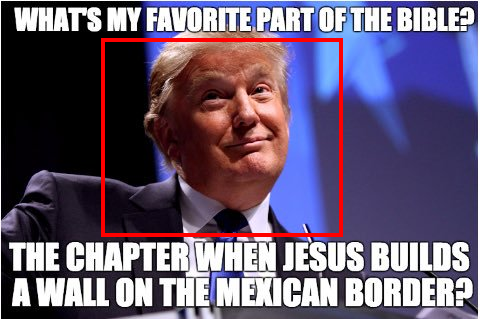

In [ ]:
img_path = "/data/guojian.li/Dataset/MSTI/img/4680.jpg"
image = Image.open(img_path)
label_path = os.path.join(VISUAL_LABEL_DIR, '4680.txt')
label = load_gt_boxes(label_path)
print(label)
plot_bounding_boxes(image,f'[{{"bbox_2d": {label[0]}}}]',image.size[0],image.size[1])

In [ ]:
text_path = "/data/guojian.li/Dataset/MSTI/Textual sentences/test/202.txt"
img_path = "/data/guojian.li/Dataset/MSTI/img/202.jpg"
image1 = Image.open(img_path)
text = load_text(text_path)
print("推文：",text)
prompt = ("Please combine the content of the tweet with the pictures to identify the targets being ridiculed in the pictures. "
"There might be multiple targets. Output all the coordinates in JSON format.")
response, input_height, input_width = qwen_infer(img_path, text, prompt, model, processor)
print("真实尺寸：",image.size)
print("变换后尺寸：",input_width,input_height)
print("真实坐标",label)
print("模型回答",response)

plot_bounding_boxes(image1,response,input_width,input_height)

NameError: name 'Image' is not defined

In [2]:
import os,re
import json
from PIL import Image
from transformers import Qwen2_5_VLForConditionalGeneration, AutoProcessor
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm


def inference(image_path, prompt, sys_prompt="""You are a helpful assistant
   """, 
max_new_tokens=4096, return_input=False):
    image = Image.open(image_path)
    image_local_path = "file://" + image_path
    messages = [
        {"role": "system", "content": sys_prompt},
        {"role": "user", "content": [
                {"type": "text", "text": prompt},
                {"image": image_local_path},
            ]
        },
    ]
    text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    # print("text:", text)
    # image_inputs, video_inputs = process_vision_info([messages])
    inputs = processor(text=[text], images=[image], padding=True, return_tensors="pt")
    inputs = inputs.to('cuda:1')

    output_ids = model.generate(**inputs, max_new_tokens=max_new_tokens)
    generated_ids = [output_ids[len(input_ids):] for input_ids, output_ids in zip(inputs.input_ids, output_ids)]
    output_text = processor.batch_decode(generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True)
    if return_input:
        return output_text[0], inputs
    else:
        return output_text[0]

# 路径配置
MODEL_PATH = "/data/guojian.li/Weight/Qwen2.5-VL-7B-Instruct/"
IMG_DIR = "/data/guojian.li/Dataset/MMSD/dataset_image/"
DATA_JSON = "/data/guojian.li/Dataset/MMSD/text_json_final/test.json"

# 加载模型与处理器
device = "cuda:1" if torch.cuda.is_available() else "cpu"
model = Qwen2_5_VLForConditionalGeneration.from_pretrained(MODEL_PATH, torch_dtype=torch.bfloat16, 
                                                           attn_implementation="flash_attention_2",device_map=device)
processor = AutoProcessor.from_pretrained(MODEL_PATH)

def predict_sarcasm(image_path, text):
    # image = Image.open(image_path).convert("RGB")
    prompt = (
        f""" 
            Please output strictly in accordance with the following XML-like structure:\n
            '<think> Natural Language Interpretation </think><bbox_2d> coordinates or none</bbox_2d><answer> sarcasm/non-sarcasm </answer>'\n\n
            Explanation:\n
            1. In <think> Explain 'Why judge (not) sarcasm'.\n
            2. <bbox_2d> section:\n
                If answer= sarcasm, give the coordinates of satirical target:'[x1,y1,x2,y2],[x1,y1,x2,y2]'. 
                    The target of satire may be more than one, or there may be none. If not, write single token 'none'.\n
                If answer= non-sarcasm, write single token 'none'.\n
            3. Only output the above three tags. The order of the tags cannot be changed. The tag name, Angle brackets, and slashes must be complete.\n\n

            Text:{text}\n
            Please judge whether this picture and text are satirical. If so, point out the location of the satirical target and give the reason.\n
            There are only two categories: sarcasm and non-sarcasm. Just output it in the prescribed format. No extra text is needed.
        """
    )
    # inputs = processor(text=prompt, images=image, return_tensors="pt").to(device)
    # outputs = model.generate(**inputs, max_new_tokens=20)
    # response = processor.batch_decode(outputs, skip_special_tokens=True)[0].strip()

    response = inference(image_path, prompt)

    with open("./data/output2.txt", "a", encoding="utf-8") as file:
        file.write("\n" + response)  # 追加一行

    match = re.search(r'<answer>(.*?)</answer>', string=response)

    if match:
        answer = match.group(1)
        # 简单的输出判定，可根据实际微调
        if "sarcasm" == answer:
            return 1
        else:
            return 0
    else:
        print(f"未能正确解析响应: {response}")
        return 1

def main():
    with open(DATA_JSON, "r", encoding="utf-8") as f:
        data = json.load(f)

    y_true, y_pred = [], []
    for item in tqdm(data):
        image_id = item["image_id"]
        text = item["text"]
        label = item["label"]
        image_path = os.path.join(IMG_DIR, f"{image_id}.jpg")
        if not os.path.exists(image_path):
            print(f"图片不存在: {image_path}")
            continue
        pred_label = predict_sarcasm(image_path, text)
        y_true.append(label)
        y_pred.append(pred_label)

    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f"准确率: {acc:.4f}")
    print(f"精确率: {precision:.4f}")
    print(f"召回率: {recall:.4f}")
    print(f"F1分数: {f1:.4f}")

if __name__ == "__main__":
    main()


  2%|▏         | 52/2409 [03:21<2:32:16,  3.88s/it]


KeyboardInterrupt: 

In [1]:
import os,re
import json
from PIL import Image
from transformers import Qwen2_5_VLForConditionalGeneration, AutoProcessor
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm


def inference(image_path, prompt, sys_prompt=(
    "You are a multimodal satire analysis assistant.\n"
    "Please output strictly in accordance with the following structure:\n"
    "'<think> Natural Language Interpretation </think><bbox_2d> coordinates or none</bbox_2d><answer> sarcasm/non-sarcasm </answer>'\n\n"
    
    "Explanation:\n"
    "1. In <think> Explain 'Why judge (not) sarcasm'.You need to think step by step and carefully analyze the relationship between the text and the images\n"
    "2. <bbox_2d> section:\n"
        "If answer= sarcasm, give the coordinates of satirical target '[x1,y1,x2,y2] ,[x1,y1,x2,y2]'. "
        "The target of satire may be more than one, or there may be none. If not, write single token 'none'.\n"
        "If answer= non-sarcasm, write single token 'none'."
    "3. Only output the above three tags. The order of the tags cannot be changed. The tag name, Angle brackets, and slashes must be complete.\n\n"
    
    "The following are some relevant examples:\n"
    "1.An example of satire:\n"
        "<think> The description of the environment in the text does not match the promotion, and irony is used to express satire. </think>"
        "<bbox_2d>[23,45,44,78],[10,20,32,40]</bbox_2d><answer> sarcasm </answer>\n"
    "2.An example of non-sarcasm:\n"
        "<think> The text normally describes the feelings brought by fine weather, without any sarcasm. </think>"
        "<bbox_2d>none</bbox_2d><answer> non-sarcasm </answer>"
), 
max_new_tokens=4096, return_input=False):
    image = Image.open(image_path)
    image_local_path = "file://" + image_path
    messages = [
        {"role": "system", "content": sys_prompt},
        {"role": "user", "content": [
                {"type": "text", "text": prompt},
                {"image": image_local_path},
            ]
        },
    ]
    text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    # print("text:", text)
    # image_inputs, video_inputs = process_vision_info([messages])
    inputs = processor(text=[text], images=[image], padding=True, return_tensors="pt")
    inputs = inputs.to('cuda:1')

    output_ids = model.generate(**inputs, max_new_tokens=max_new_tokens)
    generated_ids = [output_ids[len(input_ids):] for input_ids, output_ids in zip(inputs.input_ids, output_ids)]
    output_text = processor.batch_decode(generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True)
    if return_input:
        return output_text[0], inputs
    else:
        return output_text[0]

# 路径配置
MODEL_PATH = "/data/guojian.li/Weight/Qwen2.5-VL-7B-Instruct/"
IMG_DIR = "/data/guojian.li/Dataset/MMSD/dataset_image/"
DATA_JSON = "/data/guojian.li/Dataset/MMSD/text_json_final/test.json"

# 加载模型与处理器
device = "cuda:1" if torch.cuda.is_available() else "cpu"
model = Qwen2_5_VLForConditionalGeneration.from_pretrained(MODEL_PATH, torch_dtype=torch.bfloat16, 
                                                           attn_implementation="flash_attention_2",device_map=device)
processor = AutoProcessor.from_pretrained(MODEL_PATH)

def predict_sarcasm(image_path, text):
    # image = Image.open(image_path).convert("RGB")
    prompt = (
        f"""
            Text:{text}\n
            Please judge whether this picture and text are satirical. If so, point out the location of the satirical target and give the reason.
            You need to think step by step and carefully analyze the relationship between the text and the images. Just output it in the prescribed format. No extra text is needed.
        """
    )
    # inputs = processor(text=prompt, images=image, return_tensors="pt").to(device)
    # outputs = model.generate(**inputs, max_new_tokens=20)
    # response = processor.batch_decode(outputs, skip_special_tokens=True)[0].strip()

    response = inference(image_path, prompt)

    with open("./data/output2.txt", "a", encoding="utf-8") as file:
        file.write("\n" + response)  # 追加一行


    match = re.search(r'<answer>(.*?)</answer>', string=response)

    if match:
        answer = match.group(1)
        # 简单的输出判定，可根据实际微调
        if "sarcasm" == answer:
            return 1
        else:
            return 0
    else:
        print(f"未能正确解析响应: {response}")
        return 1

def main():
    with open(DATA_JSON, "r", encoding="utf-8") as f:
        data = json.load(f)

    y_true, y_pred = [], []
    for item in tqdm(data):
        image_id = item["image_id"]
        text = item["text"]
        label = item["label"]
        image_path = os.path.join(IMG_DIR, f"{image_id}.jpg")
        if not os.path.exists(image_path):
            print(f"图片不存在: {image_path}")
            continue
        pred_label = predict_sarcasm(image_path, text)
        y_true.append(label)
        y_pred.append(pred_label)

    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f"准确率: {acc:.4f}")
    print(f"精确率: {precision:.4f}")
    print(f"召回率: {recall:.4f}")
    print(f"F1分数: {f1:.4f}")

if __name__ == "__main__":
    main()


/opt/conda/envs/video-r1/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[2025-07-01 15:12:41,920] [INFO] [real_accelerator.py:219:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/opt/conda/envs/video-r1/compiler_compat/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status
/opt/conda/envs/video-r1/compiler_compat/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status
Loading checkpoint shards: 100%|██████████| 5/5 [00:03<00:00,  1.37it/s]
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
  7%|▋         | 158/2409 [12:35<27:45:52, 44.40s/it]

未能正确解析响应: <think> The text expresses relief or satisfaction ("that's cool") despite the inconvenience of having to rent a car and book a non-refundable hotel room. This could be interpreted as sarcasm, suggesting that the situation is not actually cool at all. However, the image shows a news article about a cancelled concert, which might imply that the person is not actually on their way to the location mentioned in the text. This creates a humorous contrast between the text and the image.</think><bbox_2d>[69,514,432,695] [58,705,234,732] [60,735,233,760] [60,764,233,789] [60,790,233,815] [60,816,233,841] [60,841,233,866] [60,866,233,891] [60,891,233,916] [60,916,233,941] [60,941,233,966] [60,966,233,991] [60,991,233,1016] [60,1016,233,1041] [60,1041,233,1066] [60,1066,233,1091] [60,1091,233,1116] [60,1116,233,1141] [60,1141,233,1166] [60,1166,233,1191] [60,1191,233,1216] [60,1216,233,1241] [60,1241,233,1266] [60,1266,233,1291] [60,1291,233,1316] [60,1316,233,1341] [60,1341,233,1366] [

 21%|██        | 499/2409 [37:19<23:49:55, 44.92s/it]

未能正确解析响应: <think> The text "please submit your butthurt form asap to... not me.." suggests that the speaker is not interested in filling out the form themselves, which could imply a sarcastic tone. The form itself is a humorous exaggeration of online harassment complaints, which might be seen as a form of satire targeting the overreaction to minor online conflicts.</think><bbox_2d>[6,149,17,164] [10,158,17,172] [10,172,17,186] [10,186,17,200] [10,200,17,214] [10,214,17,228] [10,228,17,242] [10,242,17,256] [10,256,17,270] [10,270,17,284] [10,284,17,298] [10,298,17,312] [10,312,17,326] [10,326,17,340] [10,340,17,354] [10,354,17,368] [10,368,17,382] [10,382,17,396] [10,396,17,410] [10,410,17,424] [10,424,17,438] [10,438,17,452] [10,452,17,466] [10,466,17,480] [10,480,17,494] [10,494,17,508] [10,508,17,522] [10,522,17,536] [10,536,17,550] [10,550,17,564] [10,564,17,578] [10,578,17,592] [10,592,17,606] [10,606,17,620] [10,620,17,634] [10,634,17,648] [10,648,17,662] [10,662,17,676] [10,676,1

 28%|██▊       | 684/2409 [51:30<21:16:46, 44.41s/it]

未能正确解析响应: <think> The text mentions a pledge related to Uber drivers, but the image shows a news headline about Uber drivers being charged with rape. This juxtaposition creates a humorous contrast that could be interpreted as sarcastic, suggesting that the pledge is not genuine or that the MP is selectively applying her stance based on the nature of the job. The text and image together imply a lack of consistency or hypocrisy.</think><bbox_2d>[496,841,777,946] [496,905,753,978] [512,965,672,1003] [512,1037,666,1064] [512,1064,666,1091] [512,1091,666,1118] [512,1118,666,1145] [512,1145,666,1172] [512,1172,666,1199] [512,1199,666,1226] [512,1226,666,1253] [512,1253,666,1280] [512,1280,666,1307] [512,1307,666,1334] [512,1334,666,1361] [512,1361,666,1388] [512,1388,666,1415] [512,1415,666,1442] [512,1442,666,1469] [512,1469,666,1496] [512,1496,666,1523] [512,1523,666,1550] [512,1550,666,1577] [512,1577,666,1604] [512,1604,666,1631] [512,1631,666,1658] [512,1658,666,1685] [512,1685,666,1712

 38%|███▊      | 921/2409 [1:09:23<18:08:42, 43.90s/it]

未能正确解析响应: <think> The text uses the term "snowflake" in a derogatory manner, which is often used to criticize people who are perceived as overly sensitive or politically correct. This is a common form of political satire directed at supporters of Donald Trump. The image shows a snowy scene with cars stuck in the snow, which could be interpreted as a visual representation of the challenges faced by those who are critical of Trump's policies. The juxtaposition of the text and the image creates a satirical effect.</think><bbox_2d>[196,276,275,332] [233,189,283,257] [238,159,277,194] [244,134,267,159] [246,116,265,134] [246,104,264,119] [246,94,263,105]  [246,85,262,94] [246,76,261,85] [246,68,260,76] [246,59,259,67] [246,50,259,59] [246,42,259,50] [246,34,259,42] [246,26,259,34] [246,18,259,26] [246,10,259,18] [246,2,259,10] [246,-1,259,2] [246,-9,259,-1] [246,-17,259,0] [246,-25,259,8] [246,-33,259,16] [246,-41,259,29] [246,-49,259,41] [246,-57,259,50] [246,-65,259,48] [246,-73,259,51] [

 61%|██████▏   | 1476/2409 [1:46:58<11:26:47, 44.17s/it]

未能正确解析响应: <think> The text contrasts the positive connotations associated with tourism with the negative connotations often linked to terrorism, suggesting that the mention of "Sambisa" might evoke thoughts of tourists rather than terrorists. This juxtaposition creates a satirical effect, as it plays on the public's expectations and the reality of the situation.</think><bbox_2d>[176,325,300,397] [532,450,630,484] [507,408,726,440] [173,450,726,523] [173,523,726,566] [173,566,726,600] [173,600,726,634] [173,634,726,668] [173,668,726,702] [173,702,726,736] [173,736,726,770] [173,770,726,804] [173,804,726,838] [173,838,726,872] [173,872,726,906] [173,906,726,940] [173,940,726,974] [173,974,726,1008] [173,1008,726,1042] [173,1042,726,1076] [173,1076,726,1110] [173,1110,726,1144] [173,1144,726,1178] [173,1178,726,1212] [173,1212,726,1246] [173,1246,726,1280] [173,1280,726,1314] [173,1314,726,1348] [173,1348,726,1382] [173,1382,726,1416] [173,1416,726,1450] [173,1450,726,1484] [173,1484,726,

 74%|███████▍  | 1783/2409 [2:08:30<7:42:49, 44.36s/it] 

未能正确解析响应: <think> The text questions why ISIS would know the name of an FTL shooter before it was released, which implies a level of foreknowledge that seems unlikely or suspicious. This could be interpreted as sarcastic, suggesting that such knowledge is extraordinary or impossible.</think><bbox_2d>[69,700,120,762] [138,704,158,762] [110,704,138,762] [158,704,178,762] [178,704,200,762] [200,704,220,762] [220,704,240,762] [240,704,260,762] [260,704,280,762] [280,704,300,762] [300,704,320,762] [320,704,340,762] [340,704,360,762] [360,704,380,762] [380,704,400,762] [400,704,420,762] [420,704,440,762] [440,704,460,762] [460,704,480,762] [480,704,500,762] [500,704,520,762] [520,704,540,762] [540,704,560,762] [560,704,580,762] [580,704,600,762] [600,704,620,762] [620,704,640,762] [640,704,660,762] [660,704,680,762] [680,704,700,762] [680,704,700,762] [680,704,700,762] [680,704,700,762] [680,704,700,762] [680,704,700,762] [680,704,700,762] [680,704,700,762] [680,704,700,762] [680,704,700,762

 89%|████████▉ | 2139/2409 [2:33:15<3:17:48, 43.96s/it]

未能正确解析响应: <think> The text criticizes the BC Liberal government's response to food insecurity by suggesting that they should stop providing statistics about the issue. This implies that the government is not addressing the problem seriously, which is a form of satire targeting the government's inaction.</think><bbox_2d>[69,405,150,510] [174,403,266,544] [248,366,361,574] [329,390,474,600] [429,405,564,641] [548,404,756,724] [358,359,475,575] [137,379,174,426] [138,412,174,459] [170,414,204,459] [104,390,138,432] [104,432,149,508] [138,456,174,514] [170,456,204,514] [204,456,248,514] [248,456,282,514] [282,456,326,514] [326,456,361,514] [361,456,405,514] [405,456,449,514] [449,456,493,514] [493,456,537,514] [537,456,581,514] [581,456,625,514] [625,456,669,514] [669,456,713,514] [713,456,756,514] [713,514,756,575] [713,575,756,636] [713,636,756,697] [713,697,756,756] [713,756,756,816] [713,816,756,876] [713,876,756,928] [713,928,756,980] [713,980,756,1036] [713,1036,756,1088] [713,1088,7

100%|██████████| 2409/2409 [2:50:16<00:00,  4.24s/it]  

准确率: 0.6335
精确率: 0.5556
召回率: 0.7416
F1分数: 0.6353
